Hyperparameter tuning and model validation

In [1]:
from e3fp.fingerprint.fprint import Fingerprint
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.metrics.array_metrics import tanimoto
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import pickle
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
logP = pickle.load(open("logp_df.p", "rb"))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(logP['fingerprint'], logP['logp'], test_size=0.2, random_state=42)

In [4]:
X_train_db = FingerprintDatabase(fp_type=Fingerprint, name="X_train")
X_train_db.add_fingerprints(X_train.values)
X_train_db_fold = X_train_db.fold(1024)

In [5]:
param = {
    'kernel': [tanimoto],
    'degree' : [3,8],
    'coef0' : [0.01,10,0.5],
    'gamma': ['scale', 'auto'],
    'C': [1, 5, 10]
}
                           
grid = GridSearchCV(SVR(), param_grid=param, cv=5, verbose=1)
grid.fit(X_train_db_fold.array, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'gamma': ['scale', 'auto'],
                         'kernel': [<function tanimoto at 0x10faa13a0>]},
             verbose=1)

In [6]:
grid.best_params_

{'C': 5,
 'coef0': 0.01,
 'degree': 3,
 'gamma': 'scale',
 'kernel': <function e3fp.fingerprint.metrics.array_metrics.tanimoto(X, Y=None)>}

In [7]:
clf = SVR(C=5, degree=3, kernel=tanimoto )
clf.fit(X_train_db_fold.array, y_train)

SVR(C=5, kernel=<function tanimoto at 0x10faa13a0>)

In [13]:
X_test_db = FingerprintDatabase(fp_type=Fingerprint, name="X_test")
X_test_db.add_fingerprints(X_test.values)
X_test_db_fold = X_test_db.fold(1024)

y_pred = clf.predict(X_test_db_fold.array)

In [12]:
r2_score(y_pred, y_test)

0.9013064925700364

In [14]:
db = FingerprintDatabase(fp_type=Fingerprint, name="logp")
db.add_fingerprints(logP.fingerprint)
db_fold = db.fold(1024)

In [25]:
logP['pred_logp'] = clf.predict(db_fold.array)

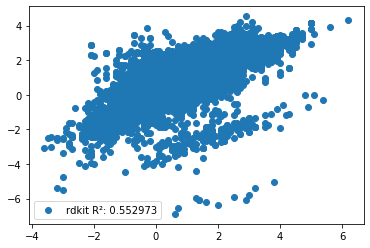

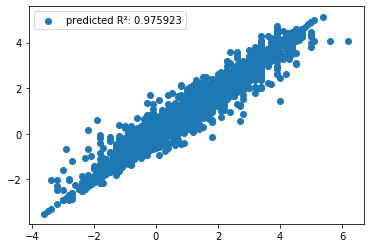

In [27]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], label='rdkit R²: %f' % r2)
pyplot.legend()
pyplot.show()

r2 = r2_score(logP['logp'], logP['pred_logp'])
pyplot.scatter(logP['logp'], logP['pred_logp'], label='predicted R²: %f' % r2)
pyplot.legend()
pyplot.show()

Conclusion: The model performs relatively well and for this dataset is a significant improvement over the results from Rdkit's implementation of the method developed by Wildman and Crippen.

Wildman, S., Crippen, G. Prediction of Physicochemical Parameters by Atomic Contributions. J. Chem. Inf. Comput. Sci 868-873 (1999)